In [1]:
%matplotlib inline

# Imports

In [2]:
import joblib
import pandas as pd
import glob

import numpy as np
from matplotlib import pyplot as plt

# Plotting parameters

In [3]:
import matplotlib
###Default for jupyter display
matplotlib.rcParams['figure.dpi']= 150

matplotlib.rcParams['xtick.labelsize'] = 7
matplotlib.rcParams['ytick.labelsize'] = 7
matplotlib.rcParams['axes.labelsize'] = 7
matplotlib.rcParams['axes.titlesize'] = 7

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.8'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True
# matplotlib.rcParams['text.usetex'] = True

matplotlib.rcParams['legend.fontsize'] = 7
matplotlib.rcParams['legend.handlelength'] = 1
matplotlib.rcParams['legend.handleheight'] = 1
matplotlib.rcParams['legend.handletextpad'] = 0.4



prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Read in / process data

In [4]:
###Load classifier model
# clf = joblib.load('../Data/classifier_data/rf_best.joblib')
clf = joblib.load('../Data/classifier_data/rf_highMinAJH.joblib')

###Load datasets
train_df = pd.read_csv('../Data/classifier_data/train_df.csv', index_col=0)
print(train_df.shape)
test_df = pd.read_csv('../Data/classifier_data/test_df.csv', index_col=0)
print(test_df.shape)

(634, 229)
(423, 229)


**Integrate my predictions into the training/testing dataframes**

In [5]:
train_df['my_predictions'] = clf.predict(train_df[train_df.columns[23:]])
test_df['my_predictions'] = clf.predict(test_df[test_df.columns[23:]])

In [6]:
train_df['my_predictions'] = train_df['my_predictions'].replace(1, 'yes')
train_df['my_predictions'] = train_df['my_predictions'].replace(0, 'no')

test_df['my_predictions'] = test_df['my_predictions'].replace(1, 'yes')
test_df['my_predictions'] = test_df['my_predictions'].replace(0, 'no')

**Integrate PHACTS predictions into dataframe**

In [7]:
for df in [train_df, test_df]:
    listy = []
    for index in df.index[:]:
        name = df.loc[index]['Identifier_AJH']
        phacts_out = '../Data/phage_data_nmicro2017/PHACTS_results/{}_prodigal.out'.format(name)
        name2 = phacts_out.split('/')[-1].split('_prodigal.out')[0]
        assert name == name2
        phacts_df = pd.read_csv(phacts_out, sep='\t', skiprows=3, header=None)
        assert phacts_df.iloc[0][1] >= phacts_df.iloc[1][1]
        if phacts_df.iloc[0][1] == phacts_df.iloc[1][1]:
            listy.append('-')
            continue
        if phacts_df.iloc[0][0] == 'Temperate':
            listy.append('yes')
        else:
            listy.append('no')
    df['Temperate_PHACTS'] = listy

# Assess accuracies

In [8]:
###Training set
my_train_errors = train_df[train_df['Temperate (empirical)'] != 
                           train_df['my_predictions']].shape[0]

mavrich_train_errors = train_df[train_df['Temperate (empirical)'] != 
                           train_df['Temperate (bioinformatically predicted)']].shape[0]

phacts_train_errors = train_df[train_df['Temperate (empirical)'] != 
                           train_df['Temperate_PHACTS']].shape[0]

print('Out of a total {}'.format(train_df.shape[0]))
print('My method had {}'.format(my_train_errors))
print('Other method had {}'.format(mavrich_train_errors))
print('PHACTS method had {}'.format(phacts_train_errors))

my_train_errors = my_train_errors / train_df.shape[0] * 100
mavrich_train_errors = mavrich_train_errors / train_df.shape[0] * 100
phacts_train_errors = phacts_train_errors / train_df.shape[0] * 100

Out of a total 634
My method had 1
Other method had 24
PHACTS method had 120


In [9]:
###Test set
my_test_errors = test_df[test_df['Temperate (empirical)'] != 
                           test_df['my_predictions']].shape[0]

mavrich_test_errors = test_df[test_df['Temperate (empirical)'] != 
                           test_df['Temperate (bioinformatically predicted)']].shape[0]

phacts_test_errors = test_df[test_df['Temperate (empirical)'] != 
                           test_df['Temperate_PHACTS']].shape[0]

print('Out of a total {}'.format(test_df.shape[0]))
print('My method had {}'.format(my_test_errors))
print('Other method had {}'.format(mavrich_test_errors))
print('PHACTS method had {}'.format(phacts_test_errors))

my_test_errors = my_test_errors / test_df.shape[0] * 100
mavrich_test_errors = mavrich_test_errors / test_df.shape[0] * 100
phacts_test_errors = phacts_test_errors / test_df.shape[0] * 100

Out of a total 423
My method had 7
Other method had 19
PHACTS method had 89


In [10]:
1-(19/423)
# 1-(1/634)

0.9550827423167849

# Further split the test set into easy/difficult sets

**According to some pre-calculated clusters of data, this splits the test set up specifically according to whether or not a related sequence (from the same cluster) was / was not included in the training set. The goal is to assess accuracy on an un-polluted (as much as possible) test set**

See `cluster_seqs.ipynb` for details

In [11]:
import json
with open('../Data/fastANI_output/clusters.json', 'r') as infile:
    clusters = json.load(infile)

In [12]:
temp_names = list(train_df['Identifier_AJH'])
independent_set = []
related_set = []
for cluster in clusters:
    hits = []
    for member in cluster:
        if member in temp_names:
            hits.append(member)
    if len(hits) == 0:
        independent_set.extend(cluster)
    else:
        related_set.extend(cluster)
###Get the challenging/easy sets        
independent_df = test_df[test_df['Identifier_AJH'].isin(independent_set)]
print(independent_df.shape)
related_df = test_df[test_df['Identifier_AJH'].isin(related_set)]
print(related_df.shape)

(172, 231)
(251, 231)


In [13]:
my_independent_errors = independent_df[independent_df['Temperate (empirical)'] != 
                           independent_df['my_predictions']].shape[0] /\
                            independent_df.shape[0] * 100.

mavrich_independent_errors = independent_df[independent_df['Temperate (empirical)'] != 
                           independent_df['Temperate (bioinformatically predicted)']].shape[0] /\
                            independent_df.shape[0] * 100.

phacts_independent_errors = independent_df[independent_df['Temperate (empirical)'] != 
                           independent_df['Temperate_PHACTS']].shape[0] /\
                            independent_df.shape[0] * 100.



my_related_errors = related_df[related_df['Temperate (empirical)'] != 
                           related_df['my_predictions']].shape[0] /\
                            related_df.shape[0] * 100.

mavrich_related_errors = related_df[related_df['Temperate (empirical)'] != 
                           related_df['Temperate (bioinformatically predicted)']].shape[0] /\
                            related_df.shape[0] * 100.

phacts_related_errors = related_df[related_df['Temperate (empirical)'] != 
                           related_df['Temperate_PHACTS']].shape[0] /\
                            related_df.shape[0] * 100.

In [14]:
100-phacts_independent_errors

81.3953488372093

# Make a final plot of the error rates

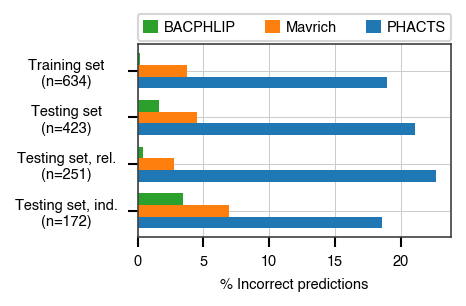

In [17]:
N = 4
my_errs = [my_train_errors, my_test_errors, my_related_errors, my_independent_errors][::-1]
mavrich_errs = [mavrich_train_errors, mavrich_test_errors, mavrich_related_errors, mavrich_independent_errors][::-1]
phacts_errs = [phacts_train_errors, phacts_test_errors, phacts_related_errors, phacts_independent_errors][::-1]

fig, ax = plt.subplots(figsize=(2.7,1.7))
ind = np.arange(N)    # the x locations for the groups
width = 0.25         # the width of the bars
p1 = ax.barh(ind, phacts_errs, width)
p2 = ax.barh(ind+width, mavrich_errs, width)
p3 = ax.barh(ind+width+width, my_errs, width)


ax.set_yticks(0.25 + np.arange(N))
ax.set_yticklabels(['Training set\n(n={})'.format(train_df.shape[0]),\
                    'Testing set\n(n={})'.format(test_df.shape[0]),\
                    'Testing set, rel.\n(n={})'.format(related_df.shape[0]),\
                    'Testing set, ind.\n(n={})'.format(independent_df.shape[0])][::-1],\
                   ha='center', )
ax.yaxis.get_majorticklabels()[0].set_x(-0.17)
ax.yaxis.get_majorticklabels()[1].set_x(-0.17)
ax.yaxis.get_majorticklabels()[2].set_x(-0.17)
ax.yaxis.get_majorticklabels()[3].set_x(-0.17)



ax.legend((p3[0], p2[0], p1[0]), ('BACPHLIP', 'Mavrich', 'PHACTS'),\
          bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode='expand', ncol=3, borderaxespad=0.)

ax.set_xlabel('% Incorrect predictions');
plt.savefig('../Manuscript/figure.png', dpi=300, bbox_inches='tight')

# Look at the feature importances

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
ax.hist(clf.feature_importances_, 20)

In [ ]:
print('This should be 1:', sum(clf.feature_importances_))
print('How many features were useless:', len([i for i in clf.feature_importances_ if i == 0]))

In [ ]:
domain_df = pd.read_csv('../Data/protein_domain_data/cddid_selected_2020_4_27.tsv', sep='\t', index_col=0)
print(domain_df.shape)
domain_df.head()

In [ ]:
zippy = list(zip(clf.feature_importances_, train_df.columns[23:-2]))
print(zippy[:5])
non_zero_cols = [i[1] for i in zippy if i[0] != 0.0]
print(len(non_zero_cols))

In [ ]:
bad_domain_df = domain_df[domain_df['1'].isin(non_zero_cols)==False]
good_domain_df = domain_df[domain_df['1'].isin(non_zero_cols)==True]
print(bad_domain_df.shape, good_domain_df.shape)

In [ ]:
for test_col in domain_df.columns[4:]:
    print(test_col, bad_domain_df[test_col].sum(), good_domain_df[test_col].sum())

**Look at most important features**

In [ ]:
zippy = list(zip(clf.feature_importances_, train_df.columns[23:-2]))
zippy = sorted(zippy, key=lambda x: x[0], reverse=True)
best_fams = [i[1] for i in zippy[:20]]
best_domain_df = domain_df[domain_df['1'].isin(best_fams)==True]
print(best_domain_df.shape)
best_domain_df


In [ ]:
print('Those best 20 domains account for {} '
      'of the overall feature importance'.format(np.sum([i[0] for i in zippy[:20]])))

# Scratch